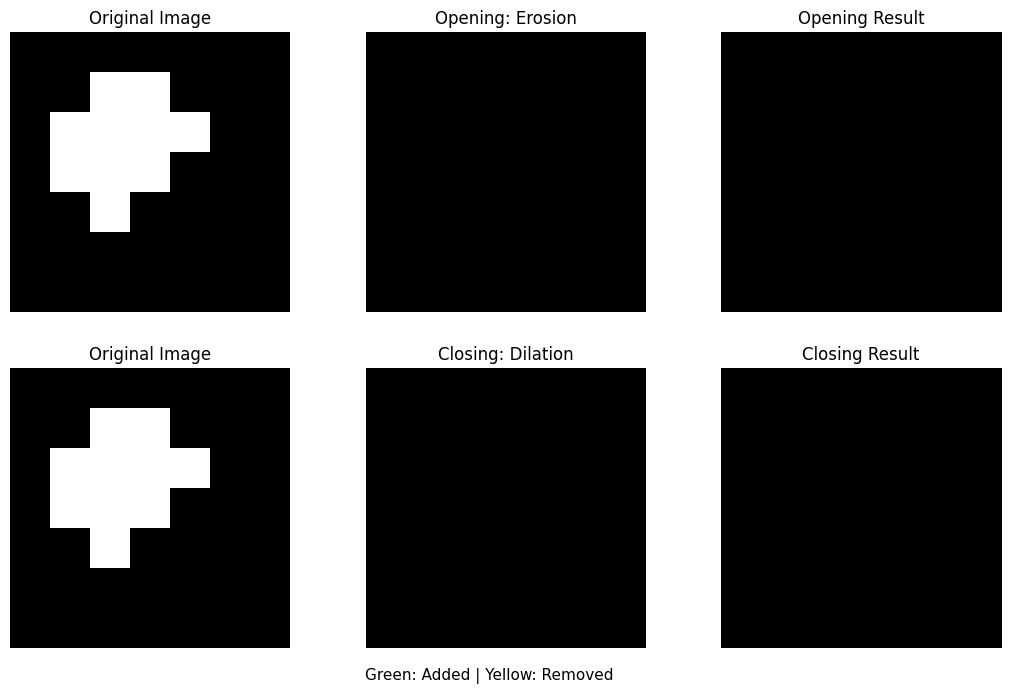

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

# ---------------------------------------------------
# 1. ORIGINAL BINARY IMAGE (0 = background, 1 = object)
# ---------------------------------------------------
image = np.array([
    [0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0],
    [0,1,1,1,1,0,0],
    [0,1,1,1,0,0,0],
    [0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
], dtype=np.uint8)

rows, cols = image.shape

# ---------------------------------------------------
# 2. STRUCTURING ELEMENT (PLUS SHAPE)
# ---------------------------------------------------
kernel = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype=np.uint8)

k = 1  # Kernel offset

# ---------------------------------------------------
# 3. MORPHOLOGICAL OPERATIONS
# ---------------------------------------------------
def erosion(img, x, y):
    for i in range(-k, k+1):
        for j in range(-k, k+1):
            if kernel[i+k, j+k]:
                xi, yj = x+i, y+j
                if xi < 0 or xi >= rows or yj < 0 or yj >= cols or img[xi, yj] == 0:
                    return 0
    return 1

def dilation(img, x, y):
    for i in range(-k, k+1):
        for j in range(-k, k+1):
            if kernel[i+k, j+k]:
                xi, yj = x+i, y+j
                if 0 <= xi < rows and 0 <= yj < cols and img[xi, yj] == 1:
                    return 1
    return 0

# ---------------------------------------------------
# 4. FULL GLOBAL RESULTS
# ---------------------------------------------------
erosion_open_full = np.zeros_like(image)
opening_full = np.zeros_like(image)
dilation_close_full = np.zeros_like(image)
closing_full = np.zeros_like(image)

for x in range(rows):
    for y in range(cols):
        erosion_open_full[x, y] = erosion(image, x, y)

for x in range(rows):
    for y in range(cols):
        opening_full[x, y] = dilation(erosion_open_full, x, y)

for x in range(rows):
    for y in range(cols):
        dilation_close_full[x, y] = dilation(image, x, y)

for x in range(rows):
    for y in range(cols):
        closing_full[x, y] = erosion(dilation_close_full, x, y)

# ---------------------------------------------------
# 5. COLOR VISUALIZATION
# ---------------------------------------------------
def colorize(base, result, mask):
    vis = np.zeros_like(base)
    for i in range(rows):
        for j in range(cols):
            if mask[i, j] == 0:
                continue
            if base[i, j] == 0 and result[i, j] == 1:
                vis[i, j] = 2  # Added (green)
            elif base[i, j] == 1 and result[i, j] == 0:
                vis[i, j] = 3  # Removed (yellow)
            elif result[i, j] == 1:
                vis[i, j] = 1  # Unchanged foreground
    return vis

# ---------------------------------------------------
# 6. ANIMATION BUFFERS
# ---------------------------------------------------
erosion_open = np.zeros_like(image)
opening = np.zeros_like(image)
dilation_close = np.zeros_like(image)
closing = np.zeros_like(image)

mask_open = np.zeros_like(image)
mask_close = np.zeros_like(image)

positions = [(i, j) for i in range(rows) for j in range(cols)]

total_erosion_removed = 0
total_dilation_added = 0
total_opening_added = 0
total_closing_removed = 0

# ---------------------------------------------------
# 7. FIGURE & COLORMAP SETUP
# ---------------------------------------------------
cmap = ListedColormap(["black", "white", "green", "yellow"])

fig, axs = plt.subplots(2, 3, figsize=(13, 8))
titles = [
    "Original Image",
    "Opening: Erosion",
    "Opening Result",
    "Original Image",
    "Closing: Dilation",
    "Closing Result"
]

ims = []
kernel_plots = []

for ax, title in zip(axs.flat, titles):
    im = ax.imshow(np.zeros_like(image), cmap=cmap, vmin=0, vmax=3)
    ims.append(im)
    ax.set_title(title)
    ax.axis("off")

    plus = [
        ax.plot([], [], marker='+', color='red',
                markersize=18, markeredgewidth=2)[0]
        for _ in range(kernel.size)
    ]
    kernel_plots.append(plus)

ims[0].set_data(image)
ims[3].set_data(image)

fig.text(0.5, 0.07, "Green: Added | Yellow: Removed", ha="center", fontsize=11)
status_text = fig.text(0.5, 0.04, "", ha="center", fontsize=11)

# ---------------------------------------------------
# 8. ANIMATION UPDATE FUNCTION
# ---------------------------------------------------
frame = 0

def update(_):
    global frame, total_erosion_removed, total_dilation_added
    global total_opening_added, total_closing_removed

    if frame >= len(positions) * 2:
        return ims

    pos_idx = frame // 2
    phase = frame % 2
    x, y = positions[pos_idx]

    for plus_list in kernel_plots:
        idx = 0
        for i in range(3):
            for j in range(3):
                if kernel[i, j]:
                    px = y + j - k
                    py = x + i - k
                    if 0 <= px < cols and 0 <= py < rows:
                        plus_list[idx].set_data(px, py)
                    else:
                        plus_list[idx].set_data([], [])
                else:
                    plus_list[idx].set_data([], [])
                idx += 1

    if phase == 1:
        erosion_open[x, y] = erosion_open_full[x, y]
        opening[x, y] = opening_full[x, y]
        mask_open[x, y] = 1

        if image[x, y] == 1 and erosion_open_full[x, y] == 0:
            total_erosion_removed += 1
        if erosion_open_full[x, y] == 0 and opening_full[x, y] == 1:
            total_opening_added += 1

        dilation_close[x, y] = dilation_close_full[x, y]
        closing[x, y] = closing_full[x, y]
        mask_close[x, y] = 1

        if image[x, y] == 0 and dilation_close_full[x, y] == 1:
            total_dilation_added += 1
        if dilation_close_full[x, y] == 1 and closing_full[x, y] == 0:
            total_closing_removed += 1

        ims[1].set_data(colorize(image, erosion_open, mask_open))
        ims[2].set_data(colorize(erosion_open_full, opening, mask_open))
        ims[4].set_data(colorize(image, dilation_close, mask_close))
        ims[5].set_data(colorize(dilation_close_full, closing, mask_close))

        status_text.set_text(
            f"Kernel at ({x},{y}) | "
            f"Erosion Removed={total_erosion_removed}, "
            f"Opening Added={total_opening_added}, "
            f"Dilation Added={total_dilation_added}, "
            f"Closing Removed={total_closing_removed}"
        )

    frame += 1
    return ims

# ---------------------------------------------------
# 9. RUN ANIMATION
# ---------------------------------------------------
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions) * 2,
    interval=500,
    repeat=False
)

plt.show()
